# Fractions Skill Score Verification - Single Hazard

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline
import pysteps
import ipywidgets as widgets
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

Pysteps configuration file found at: /anaconda3/envs/pyEAE/lib/python3.9/site-packages/pysteps/pystepsrc



### Defintions for Coarsening

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    #load the geog file produce for WRF-BCC
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    #coarsen the dataset to ~80-km
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    #assign lat/lon values of coarsen data and set index
    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [3]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc').sel(Time='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()
ds_copy_cor = Data_Conv(ds_copy)

## Create Widgets

In [4]:
#widget for selecting variable
var_widget = widgets.RadioButtons(
    options=[('Updraft Helicity', 'UH'), ('Updraft Vertical Velocity', 'UVV'), ('Downdraft Vertical Velocity', 'DVV')],
    layout={'width': 'max-content'},
    description='Variable:',
    disabled=False)

In [5]:
#widget for selecting hazard
haz_widget = widgets.RadioButtons(
    options=[('Tornado', 'tor'), ('Hail', 'hail'), ('Wind', 'wind')],
    layout={'width': 'max-content'},
    description='Hazard:',
    disabled=False)

In [6]:
#widget for selecting reflectivity range
refc_widget = widgets.IntRangeSlider(
    value=[40, 50],
    min=40,
    max=65,
    step=5,
    description='Reflectivity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [7]:
#widget for selecting reflectivity range
UVV_widget = widgets.IntRangeSlider(
    value=[18, 24],
    min=18,
    max=35,
    step=1,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [8]:
#widget for selecting reflectivity range
UH_widget = widgets.IntRangeSlider(
    value=[35, 70],
    min=35,
    max=150,
    step=5,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [9]:
#widget for selecting reflectivity range
DVV_widget = widgets.IntRangeSlider(
    value=[5, 10],
    min= 5,
    max= 15,
    step=1,
    description='Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

In [10]:
neigh_widget = widgets.IntSlider(
    value=200,
    min=0,
    max=3000,
    step=10,
    description='Pixel:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [11]:
thres_widget = widgets.IntSlider(
    value=20,
    min=0,
    max=200,
    step=1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

### Loading WRF-BCC Variable Data
The widget below allows you to select which WRF-BCC variable to currently test. NOTE: if you change the variable, you will need to rerun the cells below the widget again. You will have to run the cell above the widget before making a selection. Please select one before moving onto the next cell. After selection, you can run all cells up to the next widget.

In [12]:
#First Widget!
var_widget

RadioButtons(description='Variable:', layout=Layout(width='max-content'), options=(('Updraft Helicity', 'UH'),…

In [13]:
#load wrf-bcc dataset
df_wrf = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_{var_widget.value}_REFC_regrid_threshold_dataframe.csv')

In [31]:
#convert from raw count to convective days
df_wrf['Time'] = pd.to_datetime(df_wrf['Time'])
df_wrf

,Unnamed: 0.1,Unnamed: 0,x,y,Time,UH,DBZ,UVV,coarse_lat,coarse_lon
37,101,101,716,395,1990-10-31 02:00:00,3.842521,48.058720,25.550886,36.682777,-96.936500
44,120,120,734,412,1990-10-31 02:00:00,13.531029,49.188890,25.854595,37.271730,-96.018760
55,192,192,765,414,1990-10-31 05:00:00,8.843955,46.568184,24.174469,37.292706,-94.697970
56,193,193,766,414,1990-10-31 05:00:00,8.278842,47.737602,24.852300,37.292706,-94.648720
62,223,223,788,395,1990-10-31 07:00:00,4.016770,49.953312,24.892487,36.606743,-93.762170
...,...,...,...,...,...,...,...,...,...,...
1149285,3741184,259303,1102,146,2005-09-23 01:00:00,8.240011,50.339455,24.630083,27.234367,-82.402054
1149287,3741186,259305,1102,148,2005-09-23 01:00:00,8.934043,42.131530,25.133116,27.295202,-82.402054
1149293,3741196,259315,1094,154,2005-09-23 02:00:00,3.767740,40.888230,27.551353,27.539299,-82.681600
1149300,3741216,259335,896,365,2005-09-24 04:00:00,4.075678,56.731537,24.435700,35.348270,-89.363750


In [32]:
geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
uhs = []

for did, day in df_wrf.resample('24h', origin='1990-10-01 12:00:00', on='Time'):
    
    results = np.zeros(shape=(899, 1399))
    results[day.y.values, day.x.values] = 1
    uh_uvv = deepcopy(geog)
    uh_uvv = uh_uvv.assign_coords({'Time': np.array([did])})
    uh_uvv = uh_uvv.assign(UH_VVV_DAYS = (('Time', 'south_north', 'west_east'), np.expand_dims(results, axis=0)))
    uh_uvv = uh_uvv[['CLAT', 'CLONG', 'UVV_DAYS']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    uh_uvv['UVV_DAYS'] = 1*(uh_uvv['UVV_DAYS'] > 0)

    uhs.append(uh_uvv)
        
uhs = xr.concat(uhs, dim='Time')

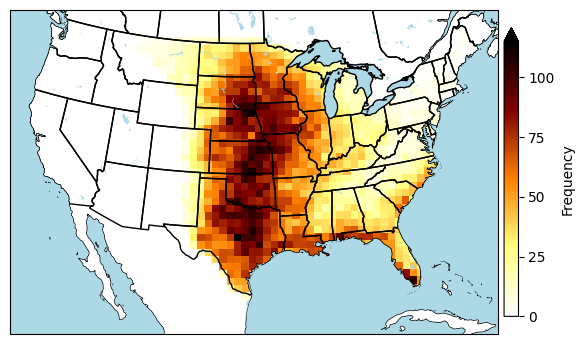

In [33]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = uhs.UH_VVV_DAYS.values
data = np.sum(data, axis=0)
#data = np.min(np.sum(data, axis=0))
#data[data==0] = np.nan
c = ax.pcolormesh(uhs.CLONG.values[0,:,:], uhs.CLAT.values[0,:,:], data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=2)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='max', ticks=list(range(0, int(np.nanmax(data)), 25)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

## Loading SPC Local Storm Report Data
The widget below allows you to select which hazard from the SPC LSR data archive file to currently test. NOTE: if you change the hazard, you will need to rerun the cells below the widget again. You will have to run the cell above the widget before making a selection. Please select one before moving onto the next cell. After selection, you can run all cells up to the next widget.

In [17]:
#Second Widget!
haz_widget

RadioButtons(description='Hazard:', layout=Layout(width='max-content'), options=(('Tornado', 'tor'), ('Hail', …

In [18]:
#load the SPC reports
#NOTE: These data have been regridded to the 80-km previously
df_obs = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_{haz_widget.value}_fix.csv')

In [34]:
#add the lat and lon columns based on values in the nearest column
lat = []
lon = []

#iterate through each row to find the lat/lon
for rid, row in df_obs.iterrows():
    lat.append(row.Nearest.split()[1])
    lon.append(row.Nearest.split()[7])

#append the values to the dataframe
df_obs['Lat'] = lat
df_obs['Lon'] = lon

#combine date and time to a datetime object
df_obs['datetime'] = pd.to_datetime(df_obs['date'] + ' ' + df_obs['time']) + pd.DateOffset(hours=6)
df_obs['con_date'] = (df_obs['datetime'] + pd.DateOffset(hours=12)).dt.date

#drop duplicates to convert to convective days
df_obs = df_obs.drop_duplicates(subset=['Lat','Lon','con_date'])
%timeit
df_obs

,Unnamed: 0.1,Unnamed: 0,om,yr,mo,dy,date,time,tz,st,...,f1,f2,f3,f4,mt,Nearest,Lat,Lon,datetime,con_date
0,0,71631,5767,1990,10,11,1990-10-11,18:30:00,3,GA,...,49,0,0,0,NaN,"(882 30.700493\nName: lat, dtype: float32, ...",30.700493,-82.248817,1990-10-12 00:30:00,1990-10-12
1,1,71632,5768,1990,10,11,1990-10-11,19:00:00,3,GA,...,25,0,0,0,NaN,"(951 31.360302\nName: lat, dtype: float32, ...",31.360302,-82.119484,1990-10-12 01:00:00,1990-10-12
2,2,71633,5769,1990,10,11,1990-10-11,21:00:00,3,GA,...,303,0,0,0,NaN,"(1088 32.792816\nName: lat, dtype: float32,...",32.792816,-82.641296,1990-10-12 03:00:00,1990-10-12
3,3,71634,5770,1990,10,12,1990-10-12,03:30:00,3,GA,...,59,0,0,0,NaN,"(1225 34.2262\nName: lat, dtype: float32, 1...",34.2262,-83.182823,1990-10-12 09:30:00,1990-10-12
5,5,71636,5772,1990,10,14,1990-10-14,18:15:00,3,WI,...,25,0,0,0,NaN,"(2044 42.98877\nName: lat, dtype: float32, ...",42.98877,-89.653122,1990-10-15 00:15:00,1990-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149332,149332,227488,10507,2005,9,9,2005-09-09,13:00:00,3,MN,...,7,0,0,0,NaN,"(2452 47.228268\nName: lat, dtype: float32,...",47.228268,-95.021698,2005-09-09 19:00:00,2005-09-10
149333,149333,227489,10508,2005,9,9,2005-09-09,13:15:00,3,MN,...,119,0,0,0,NaN,"(2520 47.90831\nName: lat, dtype: float32, ...",47.90831,-95.986839,2005-09-09 19:15:00,2005-09-10
149334,149334,227490,10509,2005,9,9,2005-09-09,14:52:00,3,UT,...,37,0,0,0,NaN,"(1469 37.189175\nName: lat, dtype: float32,...",37.189175,-109.790741,2005-09-09 20:52:00,2005-09-10
149335,149335,227491,10510,2005,9,9,2005-09-09,17:10:00,3,AZ,...,13,0,0,0,NaN,"(1121 33.566952\nName: lat, dtype: float32,...",33.566952,-111.652351,2005-09-09 23:10:00,2005-09-10


In [35]:
#create an array of zeros
zeros = np.zeros((ds_copy_cor.UP_HELI_MAX.values.shape))

#iterate through each row of the dataframe to and add one for each instance
for rid, row in df_obs.iterrows():
    y1, x1 = np.where(ds_copy_cor.lat.values == float(row.Lat))
    y2, x2 = np.where(ds_copy_cor.lon.values == float(row.Lon))
    zeros[y1[0], x2[0]] = zeros[y1[0], x2[0]] + 1
    
ds_obs = ds_copy_cor.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

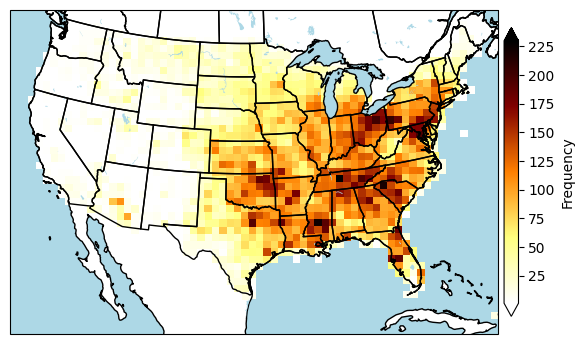

In [36]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_obs.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_copy_cor.lon.values, ds_copy_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 25)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

## Verfication Testing
There are a few widgets below, so pay attention to what each on of them does:

* **First Widget:** Controls the reflectivity range values to test on with a step interval of 5 (e.g., a range of 40-50 will test 40, 45, and 50 dBZ).
* **Second Widget:** Controls the range of values of the tested variable. These update based on the variable inputted, therefore make sure to rerun it properly. 
* **Third Widget:** Controls the neighborhood size used during the verification (e.g., 100 pixels is a 10x10 neighborhood).
* **Fourth Widget:** Controls the threshold for binarzation [e.g., 12 convective days threshold means all values above (below) become a 1 (0)]


NOTE: if you changed anything above (especially the variable), you will need to rerun the cells below that widget again. Run the cell above the widget prior to making a selection. Please adjust the widget to the desired range or value. Slowly repeat these steps for each of the widgets. 

In [22]:
# Reflectivity Widget (First)
refc_widget

IntRangeSlider(value=(40, 50), continuous_update=False, description='Reflectivity:', max=65, min=40, step=5)

In [23]:
# Varaible Widget (Second)
locals()[f'{var_widget.value}_widget']

IntRangeSlider(value=(18, 24), continuous_update=False, description='Range:', max=35, min=18)

In [24]:
# Neighborhood Widget (Third)
neigh_widget

IntSlider(value=200, continuous_update=False, description='Pixel:', max=3000, step=10)

In [25]:
# Threshold Widget (Fourth)
thres_widget

IntSlider(value=20, continuous_update=False, description='Threshold:', max=200)

### Verification with FSS

In [28]:
#Set the step value based on the variable used.
if var_widget.value == 'UH':
    step = 5
    xlabel = fr'{var_widget.value} Threshold ($m^2$ $s^{{-2}}$)'

else:
    xlabel = fr'{var_widget.value} Threshold ($m$ $s^{{-1}}$)'
    step = 1
    
    if var_widget.value == 'DVV':
        df_wrf['DVV'] = np.absolute(df_wrf['DVV'].values)

In [29]:
#create a new dataframe
df = pd.DataFrame(columns=['DBZ', 'VAR', 'FSS'])

#iterate through VAR and Z values for subsetting
for refc in np.arange(refc_widget.value[0],refc_widget.value[1]+1,5):
    for var in np.arange(locals()[f'{var_widget.value}_widget'].value[0], locals()[f'{var_widget.value}_widget'].value[1]+1, step):
        
        #subset the dataframe based on current threshold values
        df_sub = df_wrf[((df_wrf['DBZ'] >= refc) & (df_wrf[var_widget.value] >= var))]
        
        #
        geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
        uhs = []

        #
        for did, day in df_sub.resample('24h', origin='1990-10-01 12:00:00', on='Time'):

            #
            results = np.zeros(shape=(899, 1399))
            results[day.y.values, day.x.values] = 1
            uh_uvv = deepcopy(geog)
            uh_uvv = uh_uvv.assign_coords({'Time': np.array([did])})
            uh_uvv = uh_uvv.assign(UH_VVV_DAYS = (('Time', 'south_north', 'west_east'), np.expand_dims(results, axis=0)))
            uh_uvv = uh_uvv[['CLAT', 'CLONG', 'UH_VVV_DAYS']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
            uh_uvv['UH_VVV_DAYS'] = 1*(uh_uvv['UH_VVV_DAYS'] > 0)
            uhs.append(uh_uvv)

        #
        uhs = xr.concat(uhs, dim='Time')

        #verify with FSS!
        fss = pysteps.verification.spatialscores.fss(np.sum(uhs.UH_VVV_DAYS.values, axis=0), ds_obs.UP_HELI_MAX.values, 50, 100)
        
        print(f'VAR:{var}   DBZ:{refc}   DIFF:{len(df_obs) - len(df_sub)}   FSS:{fss}')
        df = df.append({'DBZ': refc, 'VAR': var, 'DIFF':len(df_obs) - len(df_sub), 'FSS':fss}, ignore_index=True)

VAR:18   DBZ:40   DIFF:-1000085   FSS:0.9871378814951085
VAR:19   DBZ:40   DIFF:-734055   FSS:0.9940582126021595
VAR:20   DBZ:40   DIFF:-524466   FSS:0.9987554449777383
VAR:21   DBZ:40   DIFF:-361381   FSS:0.9978806935174579
VAR:22   DBZ:40   DIFF:-234195   FSS:0.9880279015680957
VAR:23   DBZ:40   DIFF:-136187   FSS:0.947414330472509
VAR:24   DBZ:40   DIFF:-60458   FSS:0.8601802675570263
VAR:25   DBZ:40   DIFF:-3141   FSS:0.7042687139710074
VAR:26   DBZ:40   DIFF:39901   FSS:0.4523129682530953
VAR:27   DBZ:40   DIFF:72306   FSS:0.1682486061687698
VAR:28   DBZ:40   DIFF:96397   FSS:0.008199684133102347
VAR:18   DBZ:45   DIFF:-664888   FSS:0.9924115019591248
VAR:19   DBZ:45   DIFF:-480828   FSS:0.9979753040294987
VAR:20   DBZ:45   DIFF:-334745   FSS:0.9991499620687768
VAR:21   DBZ:45   DIFF:-220098   FSS:0.9929868296093537
VAR:22   DBZ:45   DIFF:-129793   FSS:0.9669794924914399
VAR:23   DBZ:45   DIFF:-59804   FSS:0.9009853675052528
VAR:24   DBZ:45   DIFF:-5037   FSS:0.7754890165168533
VA

### Plot Verification Results

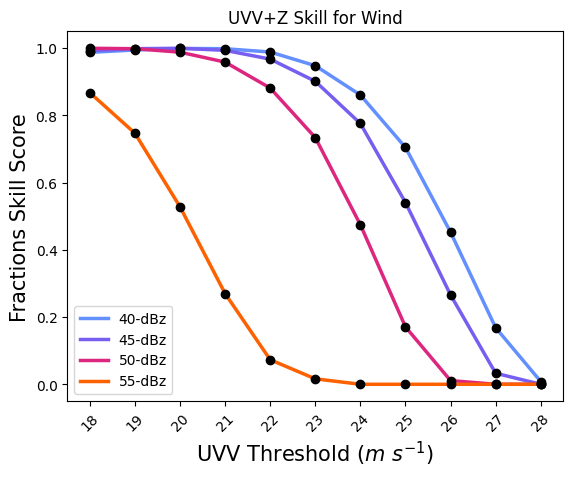

In [30]:
#create arange used commonly below
arange = np.arange(locals()[f'{var_widget.value}_widget'].value[0], locals()[f'{var_widget.value}_widget'].value[1]+1, step)
colors = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000", "black", "silver", "blue"]

#iterate through each reflectivty value
for i in range(len(np.arange(refc_widget.value[0],refc_widget.value[1]+1,5))):
    
    #plot the scores of the FSS
    plt.plot(np.arange(1,len(arange)+1,1), df.FSS.values[i*len(arange):(i+1)*len(arange)],
             color = colors[np.where(np.arange(refc_widget.value[0],refc_widget.value[1]+1,5)[i] == np.arange(40, 76, 5))[0][0]], lw=2.5)
    
#add important figure info
plt.title('FSS Verification',fontsize=25)
plt.title(f'{var_widget.value}+Z Skill for {haz_widget.label}',fontsize=12)

plt.yticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(ticks = np.arange(1,len(arange)+1,1), labels = arange, rotation=45)

plt.xlabel(xlabel, size = 15)
plt.ylabel('Fractions Skill Score', size = 15)

plt.legend([x + '-dBz' for x in list(map(str, np.arange(refc_widget.value[0],refc_widget.value[1]+1,5)))], loc ='lower left').set_zorder(12)

for i in range(len(np.arange(refc_widget.value[0],refc_widget.value[1]+1,5))):
    plt.scatter(np.arange(1,len(arange)+1,1), df.FSS.values[i*len(arange):(i+1)*len(arange)], color = 'black', zorder=10)

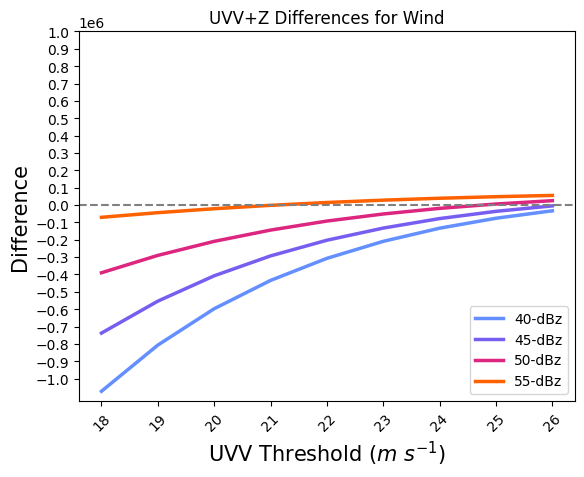

In [49]:
#iterate through each reflectivty value
for i in range(len(np.arange(refc_widget.value[0],refc_widget.value[1]+1,5))):
    
    #plot the scores of the FSS
    plt.plot(np.arange(1,len(arange)+1,1), df.DIFF.values[i*len(arange):(i+1)*len(arange)],
             color = colors[np.where(np.arange(refc_widget.value[0],refc_widget.value[1]+1,5)[i] == np.arange(40, 76, 5))[0][0]], lw=2.5)
    
plt.title(f'{var_widget.value}+Z Differences for {haz_widget.label}',fontsize=12)

plt.yticks(ticks = np.arange(-1000000, 1000001, 100000))
plt.xticks(ticks = np.arange(1,len(arange)+1,1), labels = arange, rotation=45)

plt.xlabel(xlabel, size = 15)
plt.ylabel('Difference', size = 15)

plt.legend([x + '-dBz' for x in list(map(str, np.arange(refc_widget.value[0],refc_widget.value[1]+1,5)))], loc ='lower right').set_zorder(12)

plt.axhline(y = 0.05, color = 'grey', ls='--')
    